In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import pickle
import io
import random

from scipy.stats import rankdata

## Constantes

In [2]:
plt.rcParams.update({'font.size': 16})

In [3]:
# mismas constantes que en notebook 1_...
ANIO = 2018
VENTANA = 5
DATASETS_DIR = './datasets/'

## Lee datasets

In [4]:
green = pd.read_csv(DATASETS_DIR + 'green_subset_RPOL_list.csv')
green.rename(columns={'Green HS92 codes': 'HS92'}, inplace = True)
green_codes = green.HS92.to_numpy()
green_codes = green_codes.astype(str)
green_codes.shape, green_codes.dtype

((293,), dtype('<U21'))

In [5]:
renewables = pd.read_csv(DATASETS_DIR + 'RE_subset_RPOL_list.csv')
renewables.rename(columns={'RE HS92 codes': 'HS92'}, inplace = True)
renew_codes = renewables.HS92.to_numpy()
renew_codes = renew_codes.astype(str)
renew_codes.shape, renew_codes.dtype

((57,), dtype('<U21'))

In [6]:
green.columns, renewables.columns

(Index(['HS92', 'HS92 description'], dtype='object'),
 Index(['HS92', 'HS92 description'], dtype='object'))

In [7]:
with open(f'serializables/locations_{ANIO}_{VENTANA}.pkl','rb') as f:
    locations = pickle.load(f)

paises = pd.read_csv(DATASETS_DIR + "lista_paises_iso3.csv")
paises.rename(columns={'0': 'Name'}, inplace=True)

In [8]:
with open(f'serializables/products_{ANIO}_{VENTANA}.pkl','rb') as f:
    products = pickle.load(f)

In [9]:
with open(f'serializables/proximity_{ANIO}_{VENTANA}.pkl','rb') as f:
    proximity = pickle.load(f)

In [10]:
with open(f'serializables/proximity_c_{ANIO}_{VENTANA}.pkl','rb') as f:
    proximity_c = pickle.load(f)

In [11]:
with open(f'serializables/density_{ANIO}_{VENTANA}.pkl','rb') as f:
    density_cp = pickle.load(f)

In [12]:
with open(f'serializables/export_values_{ANIO}_{VENTANA}.pkl','rb') as f:
    export_values = pickle.load(f)

In [13]:
with open(f'serializables/Mcp_{ANIO}_{VENTANA}.pkl','rb') as f:
    Mcp = pickle.load(f)

In [14]:
with open(f'serializables/eci_{ANIO}_{VENTANA}.pkl','rb') as f:
    eci = pickle.load(f)

In [15]:
with open(f'serializables/pci_{ANIO}_{VENTANA}.pkl','rb') as f:
    pci = pickle.load(f)

In [16]:
with open(f'serializables/RCA_{ANIO}_{VENTANA}.pkl','rb') as f:
    RCA = pickle.load(f)

### Toma indices de productos verdes y renovables. Toma indices de paises regionales y desarrollados.

In [17]:
green_idx = np.searchsorted(products, green_codes)
green_idx.shape, green_idx.dtype

((293,), dtype('int64'))

In [18]:
renew_idx = np.searchsorted(products, renew_codes)
renew_idx.shape, renew_idx.dtype

((57,), dtype('int64'))

In [19]:
regional_names = {
    'BRA': 'Brasil', 'MEX': 'México', 'COL': 'Colombia', 'ARG': 'Argentina', 'PER': 'Perú',
    'VEN': 'Venezuela', 'CHL': 'Chile', 'ECU': 'Ecuador', 'BOL': 'Bolivia',
    'PRY': 'Paraguay', 'URY': 'Uruguay'
}
regional_codes = list(regional_names.keys())
regional_codes

['BRA', 'MEX', 'COL', 'ARG', 'PER', 'VEN', 'CHL', 'ECU', 'BOL', 'PRY', 'URY']

"Regional" seria paises de America del Sur

In [20]:
developed_codes = ['CHN', 'ITA', 'ESP', 'FRA', 'DEU', 'TUR', 'POL', 'AUT',
                   'PRT', 'IND', 'USA', 'JPN', 'CZE', 'DNK', 'GBR']

## Complexity outlook gain

In [21]:
# calculo de distancias (ver Atlas of Complexity Economics, Hausmann et al 2014, technical box 5.4, page 62)

non_RCA_all = np.ones((len(locations), len(products)), dtype=np.int64) - Mcp
non_RCA_all = non_RCA_all.astype(float)

distance_cp = np.matmul(non_RCA_all, proximity)

for i in range(len(products)):
    distance_cp[:, i] = distance_cp[:, i]/proximity[i, :].sum()
    
inv_distance_cp = np.ones((len(locations), len(products)), float) - distance_cp

In [22]:
# cog_cp = A - B

A = np.zeros((len(locations), len(products)), float)
B = np.zeros((len(locations), len(products)), float)
sum_prox = proximity.sum(axis = 0)

for l in range(len(locations)):
    if l % 13 == 0:
        print('.', end=' ')
        
    for p in range(len(products)):
        A[l, p] = (proximity[p, :]*non_RCA_all[l, :]*pci/sum_prox).sum()
        B[l, p] = inv_distance_cp[l, p]*pci[p]

. . . . . . . . . . 

In [23]:
cog_cp = A - B

In [24]:
cog_cp.shape

(122, 4864)

## Plotea grafos de proximidades

In [25]:
(proximity > 0).sum()/(len(products)**2)

0.8875822030276143

In [26]:
print(f'Porcentaje de proximidades iguales a cero: {100*(proximity == 0.0).sum()/(len(products)**2):2.2f}%')
print(f'Porcentaje de proximidades menores a 0.1: {100*(proximity < 0.1).sum()/(len(products)**2):2.2f}%')
print(f'Porcentaje de proximidades menores a 0.2: {100*(proximity < 0.2).sum()/(len(products)**2):2.2f}%')
print(f'Porcentaje de proximidades menores a 0.55: {100*(proximity < 0.55).sum()/(len(products)**2):2.2f}%')

Porcentaje de proximidades iguales a cero: 11.24%
Porcentaje de proximidades menores a 0.1: 33.56%
Porcentaje de proximidades menores a 0.2: 66.69%
Porcentaje de proximidades menores a 0.55: 99.74%


In [27]:
green_proximity = proximity[green_idx][:, green_idx].copy()

In [28]:
green_proximity = green_proximity - np.diag(np.ones(len(green_idx)))

In [29]:
print(f'Porcentaje de proximidades verdes iguales a cero: {100*(green_proximity == 0.0).sum()/(len(green_idx)**2):2.2f}%')
print(f'Porcentaje de proximidades verdes menores a 0.1: {100*(green_proximity < 0.1).sum()/(len(green_idx)**2):2.2f}%')
print(f'Porcentaje de proximidades verdes menores a 0.2: {100*(green_proximity < 0.2).sum()/(len(green_idx)**2):2.2f}%')
print(f'Porcentaje de proximidades verdes menores a 0.55: {100*(green_proximity < 0.55).sum()/(len(green_idx)**2):2.2f}%')

Porcentaje de proximidades verdes iguales a cero: 3.14%
Porcentaje de proximidades verdes menores a 0.1: 14.19%
Porcentaje de proximidades verdes menores a 0.2: 41.21%
Porcentaje de proximidades verdes menores a 0.55: 98.68%


In [30]:
green_proximity.shape

(293, 293)

In [31]:
co_code = 'ARG'
co_id = np.searchsorted(locations, co_code)
co_code, co_id

('ARG', 3)

### Grafo productos verdes + COG por color (seguimos de cerca la metodolodía del paper de Product Space, Hidalgo et al 2007)

In [32]:
nodes_to_label_d = {
    '848360': 'Embragues, acoplamientos de eje, juntas universales',
    '841410': 'Bombas de vacío',
    '848340': 'Engranajes, husillos de bolas, variadores de velocidad, conversor de par',
    '842129': 'Maquinaria de filtrado / depuración de líquidos n.e.p.',
    '842382': 'Maquinaria de pesaje con una capacidad de 30 a 5000 kg.',
    '841360': 'Bombas rotativas de desplazamiento positivo nep',
    '841350': 'Bombas recíprocas de desplazamiento positivo nep',
    '400259': 'Caucho de acrilonitrilo-butadieno (NBR) excepto como látex',
    '847982': 'Máquinas para mezclar, amasar, triturar, etc, n.e.p.',
    '841480': 'Compresores de aire o gas, campanas',
    '842191': 'Partes de centrifugadoras, incluidas las secadoras centrífugas',
    '841950': 'Unidades de intercambio de calor, no domésticas, no eléctricas',
    '842199': 'Piezas para máquinas de filtración / depuración de líquido / gas',
    '902680': 'Equipo a medir, comprobar propiedades gas / líquido n.e.p.',
    '903010': 'Instrumentos para medir o detectar radiaciones ionizantes',
    '846694': 'Piezas, accesorios n.e.p., máquinas herramienta para dar forma a metales',
    '841182': 'Motores de turbina de gas n.e.p. de potencia> 5000 kW',
    '390940': 'Resinas fenólicas, en formas primarias',
    '281512': 'Hidróxido de sodio (sosa cáustica) en solución acuosa',
    '841990': 'Piezas, laboratorio / máquina industrial de calefacción / refrigeración',
    '842220': 'Maquinaria para limpiar / secar botellas / contenedores n.e.p.',
    '841181': 'Motores de turbina de gas n.e.p. de potencia <5000 kW',
    '841370': 'Bombas centrífugas nep',
    '848110': 'Válvulas reductoras de presión',
    '842833': 'Tipo de cinta transportadora o elevadora de mercancías de acción continua',
    '850163': 'Generadores de CA, de una potencia de 375-750 kVA',
    '730431': 'Tubería de hierro / acero sin alear, estirada / laminada en frío, nep',
    '761290': 'Barriles, bidones, cajas, etc. de aluminio, capacidad <300 litros',
    '850162': 'Generadores de CA, de una potencia de 75-375 kVA',
    '841090': 'Partes de turbinas hidráulicas y ruedas hidráulicas.'
}
nodes_to_label = list(nodes_to_label_d)

How many extra edges added: 199


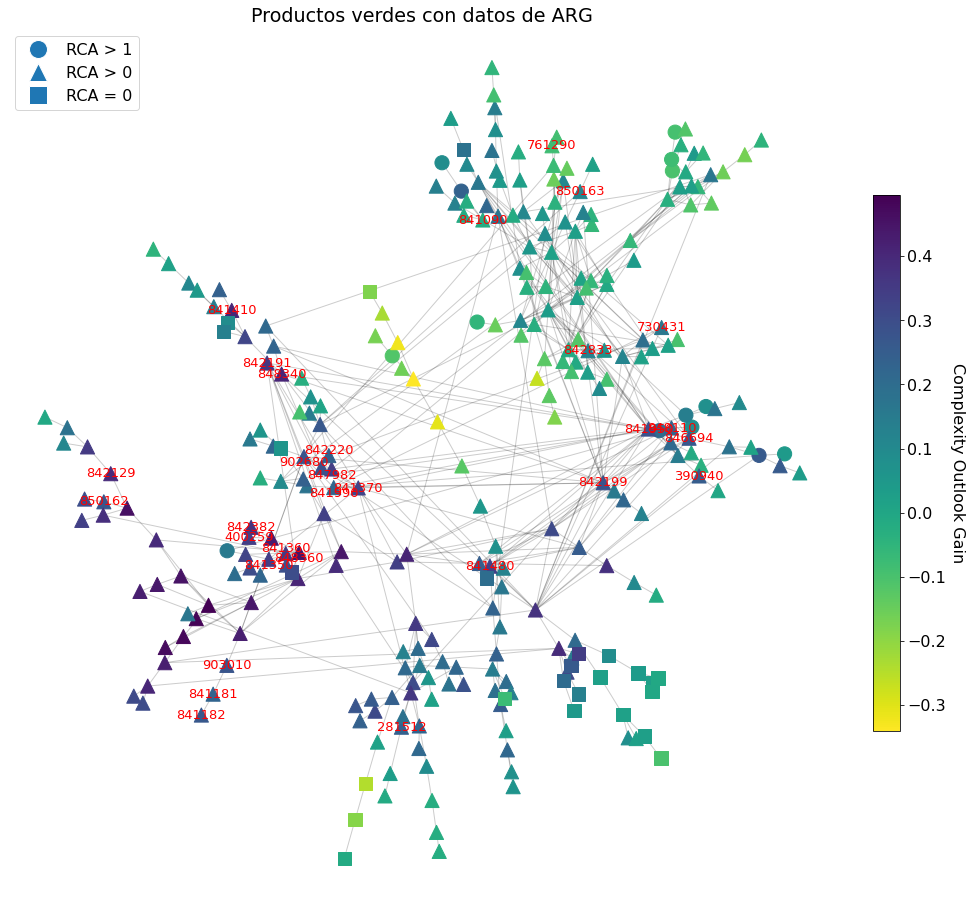

In [33]:
G = nx.from_numpy_matrix(green_proximity, parallel_edges=False, create_using=nx.Graph)
T = nx.maximum_spanning_tree(G)

q_to_color = cog_cp[co_id, green_idx]
norm = matplotlib.colors.Normalize(vmin=min(q_to_color), vmax=max(q_to_color)) 
sm = matplotlib.cm.ScalarMappable(cmap='viridis_r', norm=norm)

layo = nx.spring_layout(T, k=0.1, iterations=70, seed=1)
layo = nx.spring_layout(T, pos=layo, seed=43)

add_edges = []
bef_threshold = 0.575

for n1 in T:
    for n2 in range(n1+1, len(green_idx)):
        proxi = green_proximity[n1, n2]
        if not T.has_edge(n1, n2) and proxi > bef_threshold:
            add_edges.append([n1, n2, proxi])
print('How many extra edges added:', len(add_edges))
T.add_weighted_edges_from(add_edges)


rca_may1 = []
rca_may0 = []
rca0 = []
node_labels = {}
for node in T:
    if products[green_idx][node] in nodes_to_label:
        node_labels[node] = products[green_idx][node]
    if RCA[co_id, green_idx][node] > 1.0:
        rca_may1.append(node)
    elif RCA[co_id, green_idx][node] > 0.0:
        rca_may0.append(node)
    elif RCA[co_id, green_idx][node] == 0.0:
        rca0.append(node)
    else:
        print('ERROR: algun RCA es menor a cero?')

if len(nodes_to_label) != len(node_labels):
    print('Algunos productos de la lista no estan en el grafo, los siguientes:', end=' ')
    for no in nodes_to_label:
        if no not in node_labels.values():
            print(no, end=', ')

            
fig, ax = plt.subplots(figsize=(16, 16))
plt.title('Productos verdes con datos de ' + co_code)
plt.axis('off')

nx.draw_networkx_nodes(T, layo, nodelist=rca_may1, node_color=q_to_color[rca_may1], cmap='viridis_r', 
                       node_shape='o', node_size=200, vmin=min(q_to_color), vmax=max(q_to_color))
nx.draw_networkx_nodes(T, layo, nodelist=rca_may0, node_color=q_to_color[rca_may0], cmap='viridis_r', 
                       node_shape='^', node_size=200, vmin=min(q_to_color), vmax=max(q_to_color))
nx.draw_networkx_nodes(T, layo, nodelist=rca0, node_color=q_to_color[rca0], cmap='viridis_r', node_shape='s', 
                       node_size=180, vmin=min(q_to_color), vmax=max(q_to_color))
nx.draw_networkx_edges(T, layo, alpha=0.2)


pos_attrs = {}
for node, coords in layo.items():
    if node in node_labels.keys():
        if node_labels[node] in ['842220', '841360']:
            pos_attrs[node] = (coords[0], coords[1] + 0.01)
        elif node_labels[node] in ['841350', '848360', '902680', '847982', '841990']:
            pos_attrs[node] = (coords[0], coords[1] - 0.012)
        else:
            pos_attrs[node] = (coords[0], coords[1])
    else:
        pos_attrs[node] = (coords[0], coords[1])
        
nx.draw_networkx_labels(T, pos_attrs, labels=node_labels, font_color='red', font_size=13)


sm._A = []
cbar = ax.figure.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.ax.set_ylabel('Complexity Outlook Gain', rotation=-90, va="bottom")

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='RCA > 1',
                          markerfacecolor='tab:blue', markersize=18),
                   Line2D([0], [0], marker='^', color='w', label='RCA > 0',
                          markerfacecolor='tab:blue', markersize=18),
                   Line2D([0], [0], marker='s', color='w', label='RCA = 0',
                          markerfacecolor='tab:blue', markersize=18),]
ax.legend(handles=legend_elements, loc='upper left')

Separa productos en secciones:

In [34]:
import json
from matplotlib.colors import ListedColormap

with open(DATASETS_DIR + 'classificationH0.json') as f:
    prod_clas = json.load(f)['results']

prod_bin = {}
for cla in prod_clas:
    if len(cla['id']) == 2:
        prod_bin[int(cla['id'])] = cla['text']

In [35]:
prod_sections = [5, 14, 15, 24, 27, 38, 40, 43, 46, 49, 63, 67, 70, 71, 83, 85, 89, 92, 93, 96, 99]
prod_sections_d = {
    5: ' I Animales vivos; productos animales',
    14: ' II Productos vegetales',
    15: ' III Grasas y aceites animales o vegetales y sus derivados',
    24: ' IV Alimentos preparados, bebidas y tabaco',
    27: ' V Productos minerales',
    38: ' VI Productos químicos y aliados',
    40: ' VII Plásticos, caucho, y sus manufacturas',
    43: ' VIII Pieles, cueros, peletería. Sillería y arnés. Artículos de viaje. Artículos de tripa animal',
    46: ' IX Productos de madera, carbón de madera, o corcho. Fabricaciones de paja u otros materiales trenzados',
    49: ' X Pasta de madera u otras materias fibrosas celulosicas. Papel y carbón, y sus recuperados y manufacturas',
    63: ' XI Textiles y artículos textiles',
    67: ' XII Calzado, cascos, paraguas, bastones, plumas preparadas, flores artificiales y artículos de cabello humano',
    70: ' XIII Artículos de piedra, yeso, cemento, amianto, mica, cerámicos, y vidrios',
    71: ' XIV Perlas, piedras, metales preciosos o revestidos, joyería de imitación, y monedas',
    83: ' XV Metales comunes y sus manufacturas',
    85: ' XVI Aparatos mecánicos y eléctricos, sus partes y accesorios',
    89: ' XVII Vehículos, aviones, buques y equipos de transporte asociados',
    92: ' XVIII Óptica, fotografía, cinematografía, medición, e instrumentos médicos. Relojes, instrumentos musicales, sus partes y accesorios',
    93: ' XIX Armas y municiones, partes y accesorios',
    96: ' XX Artículos varios fabricados',
    99: ' XXI Obras de arte, piezas de coleccionista y antigüedades'
}
len(prod_sections) == len(prod_sections_d)

True

### Grafo productos verdes + secciones o clasificacion HS2 por color

How many extra edges added: 199


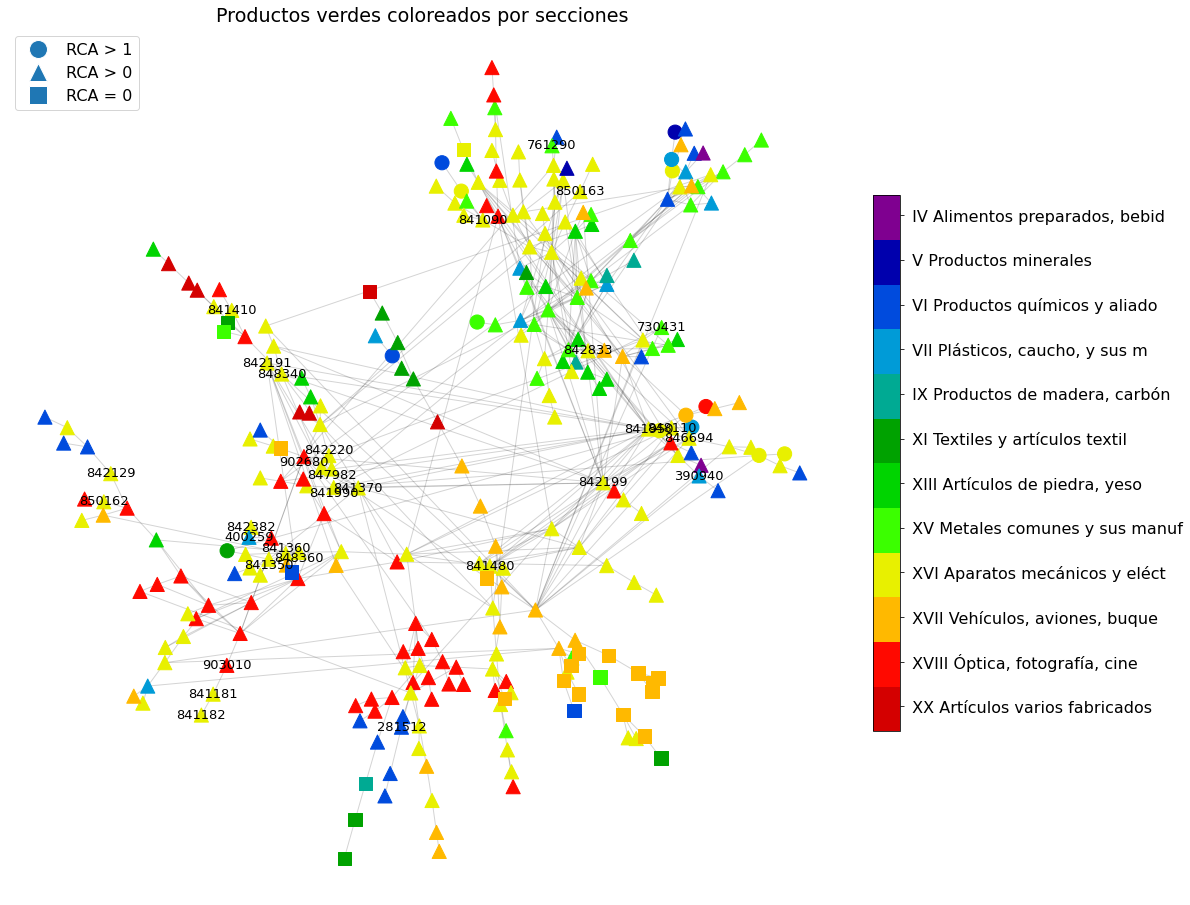

In [36]:
G = nx.from_numpy_matrix(green_proximity, parallel_edges=False, create_using=nx.Graph)
T = nx.maximum_spanning_tree(G)

layo = nx.spring_layout(T, k=0.1, iterations=70, seed=1)
layo = nx.spring_layout(T, pos=layo, seed=43)

add_edges = []
bef_threshold = 0.575

prod_types = []
node_to_section = {}
for n1 in T:
    prod_id = int(products[green_idx][n1][:2])
    
    # color with sections
    for ps in prod_sections:
        if prod_id <= ps: 
            node_to_section[n1] = ps
            if ps not in prod_types:
                prod_types.append(ps)
            break
    # color with HS2
    #if (prod_id not in prod_types):
    #    prod_types.append(prod_id)
        
    for n2 in range(n1+1, len(green_idx)):
        proxi = green_proximity[n1, n2]
        if not T.has_edge(n1, n2) and proxi > bef_threshold:
            add_edges.append([n1, n2, proxi])
print('How many extra edges added:', len(add_edges))
T.add_weighted_edges_from(add_edges)
                             

prod_types = sorted(prod_types)
prod_colors = dict(zip(sorted(prod_types), range(len(prod_types))))
prod_colors2 = dict(zip(range(len(prod_types)), sorted(prod_types)))
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(prod_types)-1) 
sm = matplotlib.cm.ScalarMappable(cmap=ListedColormap(sns.color_palette("nipy_spectral", len(prod_types))[::-1]), norm=norm)

rca_may1 = []
rca_may0 = []
rca0 = []
rca_may1_col = []
rca_may0_col = []
rca0_col = []
node_labels = {}
for node in T:
    if products[green_idx][node] in nodes_to_label:
        node_labels[node] = products[green_idx][node]
    if RCA[co_id, green_idx][node] > 1.0:
        rca_may1.append(node)
        # color with sections
        rca_may1_col.append(prod_colors[node_to_section[node]])
        # color with HS2
        #rca_may1_col.append(prod_colors[int(products[green_idx][node][:2])])
    elif RCA[co_id, green_idx][node] > 0.0:
        rca_may0.append(node)
        # color with sections
        rca_may0_col.append(prod_colors[node_to_section[node]])
        # color with HS2
        #rca_may0_col.append(prod_colors[int(products[green_idx][node][:2])])
    elif RCA[co_id, green_idx][node] == 0.0:
        rca0.append(node)
        # color with sections
        rca0_col.append(prod_colors[node_to_section[node]])
        # color with HS2
        #rca0_col.append(prod_colors[int(products[green_idx][node][:2])])
    else:
        print('ERROR: algun RCA es menor a cero?')


fig, ax = plt.subplots(figsize=(16, 16))
# color segun secciones
plt.title('Productos verdes coloreados por secciones')
# color segun HS2
#plt.title('Productos verdes con clasificación HS2')
plt.axis('off')

nx.draw_networkx_nodes(T, layo, nodelist=rca_may1, node_color=rca_may1_col, 
                       cmap=ListedColormap(sns.color_palette("nipy_spectral", len(prod_types))), 
                       node_shape='o', node_size=200, vmin=0, vmax=len(prod_types)-1)
nx.draw_networkx_nodes(T, layo, nodelist=rca_may0, node_color=rca_may0_col, 
                       cmap=ListedColormap(sns.color_palette("nipy_spectral", len(prod_types))), 
                       node_shape='^', node_size=200, vmin=0, vmax=len(prod_types)-1)
nx.draw_networkx_nodes(T, layo, nodelist=rca0, node_color=rca0_col, 
                       cmap=ListedColormap(sns.color_palette("nipy_spectral", len(prod_types))), 
                       node_shape='s', node_size=180, vmin=0, vmax=len(prod_types)-1)
nx.draw_networkx_edges(T, layo, alpha=0.17)

pos_attrs = {}
for node, coords in layo.items():
    if node in node_labels.keys():
        if node_labels[node] in ['842220', '841360']:
            pos_attrs[node] = (coords[0], coords[1] + 0.01)
        elif node_labels[node] in ['841350', '848360', '902680', '847982', '841990']:
            pos_attrs[node] = (coords[0], coords[1] - 0.012)
        else:
            pos_attrs[node] = (coords[0], coords[1])
    else:
        pos_attrs[node] = (coords[0], coords[1])
        
nx.draw_networkx_labels(T, pos_attrs, labels=node_labels, font_color='black', font_size=13)                             

sm._A = []
cbar = ax.figure.colorbar(sm, ax=ax, ticks=[0.5+i*(1 - 1/len(prod_types)) for i in range(len(prod_types))], fraction=0.03, pad=0.04)
# color segun secciones
cbar.ax.set_yticklabels(["{}".format(prod_sections_d[prod_colors2[i]][:31]) for i in range(len(prod_types))][::-1])
# color segun HS2
#cbar.ax.set_yticklabels(["{}".format(prod_bin[prod_colors2[i]][:26]) for i in range(len(prod_types))])
#cbar.ax.set_ylabel('Clasificación de productos', rotation=-90, va="bottom")

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='RCA > 1',
                          markerfacecolor='tab:blue', markersize=18),
                   Line2D([0], [0], marker='^', color='w', label='RCA > 0',
                          markerfacecolor='tab:blue', markersize=18),
                   Line2D([0], [0], marker='s', color='w', label='RCA = 0',
                          markerfacecolor='tab:blue', markersize=18),]
ax.legend(handles=legend_elements, loc='upper left')

In [37]:
to_check_graph = '''
16 a 24: 'Sec IV - Alimentos preparados, bebidas y tabaco',
25 a 27: 'Sec V - Productos minerales',
28 a 38: 'Sec VI - Productos químicos y aliados',
39 a 40: 'Sec VII - Plásticos, caucho, y sus manufacturas',
44 a 46: 'Sec IX - Productos de madera, carbón de madera, o corcho. Fabricaciones de paja u otros materiales trenzados',
50 a 63: 'Sec XI - Textiles y artículos textiles',
68 a 70: 'Sec XIII - Artículos de piedra, yeso, cemento, amianto, mica, cerámicos, y vidrios',
72 a 83: 'Sec XV - Metales comunes y sus manufacturas',
84 a 85: 'Sec XVI - Aparatos mecánicos y eléctricos, sus partes y accesorios',
86 a 89: 'Sec XVII - Vehículos, aviones, buques y equipos de transporte asociados',
90 a 92: 'Sec XVIII - Óptica, fotografía, cinematografía, medición, e instrumentos médicos. Relojes, instrumentos musicales, sus partes y accesorios',
94 a 96: 'Sec XX - Artículos varios fabricados',
'''

### Grafos productos verdes + no verdes con RCA > 1 (menos los no cercanos a verdes) + cog por color

In [38]:
new_proxi = proximity - np.diag(np.ones(len(proximity)))

#### Toma indices correspondientes a productos verdes + productos con RCA > 1 para pais en co_id

In [39]:
RCAmay1_idx = np.where(Mcp[co_id] == 1)[0]
get_idx = np.union1d(green_idx, RCAmay1_idx)
len(get_idx)

727

In [40]:
plt_proxi = new_proxi[get_idx][:, get_idx]

In [41]:
is_green = [gi in green_idx for gi in get_idx]

In [42]:
not_green = [not gi for gi in is_green]

Toma solo indices de productos RCA>1 cercanos a verdes (proximidad mayor a 0.4)

In [43]:
non_green_good_idx = np.where(plt_proxi[is_green][:, not_green].max(axis = 0) >= 0.4)[0]

In [44]:
good_idx = []
ng = 0
for i, g in enumerate(is_green):
    if g:
        good_idx.append(get_idx[i])
    else:
        if ng in non_green_good_idx:
            good_idx.append(get_idx[i])
        ng += 1

get_idx = np.array(good_idx)
get_idx.shape

(600,)

In [45]:
plt_proxi = new_proxi[get_idx][:, get_idx]
is_green = [gi in green_idx for gi in get_idx]
not_green = [not gi for gi in is_green]

How many extra edges added: 461


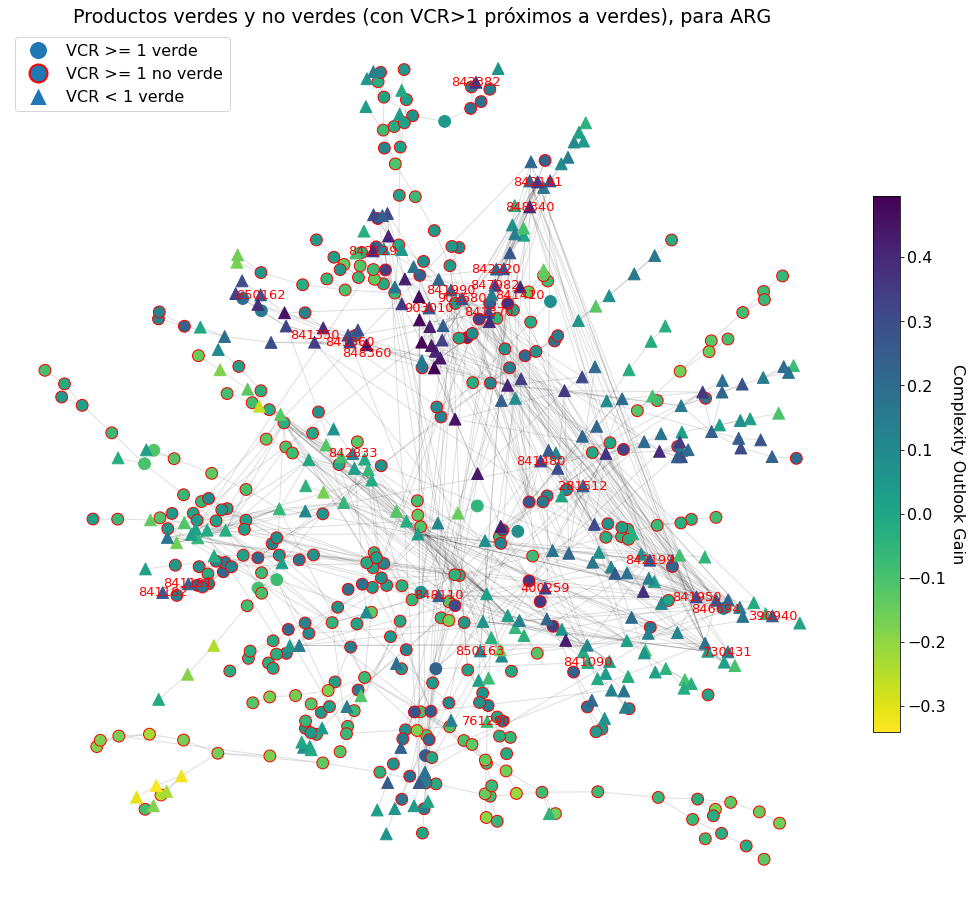

In [46]:
G = nx.from_numpy_matrix(plt_proxi, parallel_edges=False, create_using=nx.Graph)
T = nx.maximum_spanning_tree(G)

q_to_color = cog_cp[co_id, get_idx]
norm = matplotlib.colors.Normalize(vmin=min(q_to_color), vmax=max(q_to_color)) 
sm = matplotlib.cm.ScalarMappable(cmap='viridis_r', norm=norm)

layo = nx.spring_layout(T, k=0.1, iterations=80, seed=1)
layo = nx.spring_layout(T, pos=layo, seed=43)

add_edges = []
bef_threshold = 0.56

for n1 in T:
    for n2 in range(n1+1, len(get_idx)):
        proxi = plt_proxi[n1, n2]
        if not T.has_edge(n1, n2) and proxi > bef_threshold:
            add_edges.append([n1, n2, proxi])
print('How many extra edges added:', len(add_edges))
T.add_weighted_edges_from(add_edges)


rca_may1_g = []
rca_may1_nog = []
rca_men1 = []
node_labels = {}
for node in T:
    if products[get_idx][node] in nodes_to_label:
        node_labels[node] = products[get_idx][node]
    if (RCA[co_id, get_idx][node] >= 1.0) and is_green[node]:
        rca_may1_g.append(node)
    elif (RCA[co_id, get_idx][node] >= 1.0) and not is_green[node]:
        rca_may1_nog.append(node)
    elif RCA[co_id, get_idx][node] < 1.0:
        rca_men1.append(node)
    else:
        print('ERROR: ifs de RCA tienen algun problema')
if len(nodes_to_label) != len(node_labels):
    print('Algunos productos de la lista no estan en el grafo, los siguientes:', end=' ')
    for no in nodes_to_label:
        if no not in node_labels.values():
            print(no, end=', ')

fig, ax = plt.subplots(figsize=(16, 16))
plt.title('Productos verdes y no verdes (con VCR>1 próximos a verdes), para ' + co_code)
plt.axis('off')

nx.draw_networkx_nodes(T, layo, nodelist=rca_may1_g, node_color=q_to_color[rca_may1_g], cmap='viridis_r', 
                       node_shape='o', node_size=140, vmin=min(q_to_color), vmax=max(q_to_color))
nog_nodes = nx.draw_networkx_nodes(T, layo, nodelist=rca_may1_nog, node_color=q_to_color[rca_may1_nog], cmap='viridis_r', 
                       node_shape='o', node_size=140, vmin=min(q_to_color), vmax=max(q_to_color))
nog_nodes.set_edgecolor('r')
nx.draw_networkx_nodes(T, layo, nodelist=rca_men1, node_color=q_to_color[rca_men1], cmap='viridis_r', 
                       node_shape='^', node_size=140, vmin=min(q_to_color), vmax=max(q_to_color))
nx.draw_networkx_edges(T, layo, alpha=0.13)

pos_attrs = {}
for node, coords in layo.items():
    if node in node_labels.keys():
        if node_labels[node] in ['841350']:
            pos_attrs[node] = (coords[0], coords[1] + 0.015)
        elif node_labels[node] in ['841410', '846694', '848360']:
            pos_attrs[node] = (coords[0], coords[1] - 0.02)
        else:
            pos_attrs[node] = (coords[0], coords[1])
    else:
        pos_attrs[node] = (coords[0], coords[1])

nx.draw_networkx_labels(T, pos_attrs, labels=node_labels, font_color='red', font_size=13)

sm._A = []
cbar = ax.figure.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.ax.set_ylabel('Complexity Outlook Gain', rotation=-90, va="bottom")

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='VCR >= 1 verde',
                          markerfacecolor='tab:blue', markersize=18),
                   Line2D([0], [0], marker='o', color='w', label='VCR >= 1 no verde',
                          markerfacecolor='tab:blue', markeredgewidth=2.0, markeredgecolor='r', markersize=18),
                   Line2D([0], [0], marker='^', color='w', label='VCR < 1 verde',
                          markerfacecolor='tab:blue', markersize=18),]
ax.legend(handles=legend_elements, loc='upper left')

### Grafos productos verdes + no verdes con RCA > 1 (menos los no cercanos a verdes) + secciones por color

How many extra edges added: 461


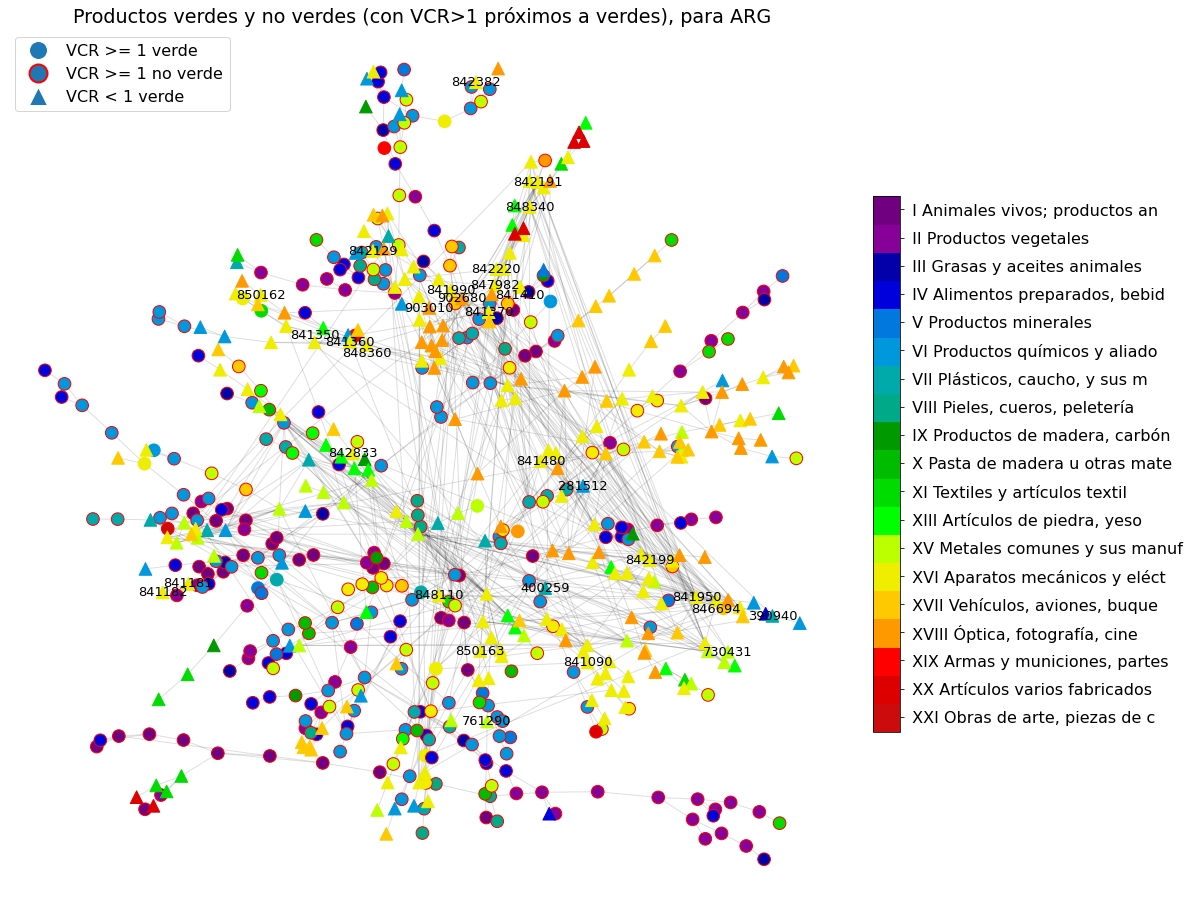

In [47]:
G = nx.from_numpy_matrix(plt_proxi, parallel_edges=False, create_using=nx.Graph)
T = nx.maximum_spanning_tree(G)

layo = nx.spring_layout(T, k=0.1, iterations=80, seed=1)
layo = nx.spring_layout(T, pos=layo, seed=43)

add_edges = []
bef_threshold = 0.56

prod_types = []
node_to_section = {}
for n1 in T:
    prod_id = int(products[get_idx][n1][:2])
    
    # color with sections
    for ps in prod_sections:
        if prod_id <= ps: 
            node_to_section[n1] = ps
            if ps not in prod_types:
                prod_types.append(ps)
            break
    
    for n2 in range(n1+1, len(get_idx)):
        proxi = plt_proxi[n1, n2]
        if not T.has_edge(n1, n2) and proxi > bef_threshold:
            add_edges.append([n1, n2, proxi])
print('How many extra edges added:', len(add_edges))
T.add_weighted_edges_from(add_edges)


prod_types = sorted(prod_types)
prod_colors = dict(zip(sorted(prod_types), range(len(prod_types))))
prod_colors2 = dict(zip(range(len(prod_types)), sorted(prod_types)))
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(prod_types)-1) 
sm = matplotlib.cm.ScalarMappable(cmap=ListedColormap(sns.color_palette("nipy_spectral", len(prod_types))[::-1]), norm=norm)

rca_may1_g = []
rca_may1_nog = []
rca_men1 = []
rca_may1_g_col = []
rca_may1_nog_col = []
rca_men1_col = []
node_labels = {}
for node in T:
    if products[get_idx][node] in nodes_to_label:
        node_labels[node] = products[get_idx][node]
    if (RCA[co_id, get_idx][node] >= 1.0) and is_green[node]:
        rca_may1_g.append(node)
        rca_may1_g_col.append(prod_colors[node_to_section[node]])
    elif (RCA[co_id, get_idx][node] >= 1.0) and not is_green[node]:
        rca_may1_nog.append(node)
        rca_may1_nog_col.append(prod_colors[node_to_section[node]])
    elif RCA[co_id, get_idx][node] < 1.0:
        rca_men1.append(node)
        rca_men1_col.append(prod_colors[node_to_section[node]])
    else:
        print('ERROR: algun problema con los ifs de RCA')


fig, ax = plt.subplots(figsize=(16, 16))
plt.title('Productos verdes y no verdes (con VCR>1 próximos a verdes), para ' + co_code)
plt.axis('off')


nx.draw_networkx_nodes(T, layo, nodelist=rca_may1_g, node_color=rca_may1_g_col, cmap=ListedColormap(sns.color_palette("nipy_spectral", len(prod_types))), 
                       node_shape='o', node_size=160, vmin=0, vmax=len(prod_types)-1)
nog_nodes = nx.draw_networkx_nodes(T, layo, nodelist=rca_may1_nog, node_color=rca_may1_nog_col, cmap=ListedColormap(sns.color_palette("nipy_spectral", len(prod_types))), 
                       node_shape='o', node_size=160, vmin=0, vmax=len(prod_types)-1)
nog_nodes.set_edgecolor('r')
nx.draw_networkx_nodes(T, layo, nodelist=rca_men1, node_color=rca_men1_col, cmap=ListedColormap(sns.color_palette("nipy_spectral", len(prod_types))), 
                       node_shape='^', node_size=160, vmin=0, vmax=len(prod_types)-1)
nx.draw_networkx_edges(T, layo, alpha=0.13)

pos_attrs = {}
for node, coords in layo.items():
    if node in node_labels.keys():
        if node_labels[node] in ['841350']:
            pos_attrs[node] = (coords[0], coords[1] + 0.015)
        elif node_labels[node] in ['841410', '846694', '848360']:
            pos_attrs[node] = (coords[0], coords[1] - 0.02)
        else:
            pos_attrs[node] = (coords[0], coords[1])
    else:
        pos_attrs[node] = (coords[0], coords[1])
        
nx.draw_networkx_labels(T, pos_attrs, labels=node_labels, font_color='black', font_size=13)

sm._A = []
cbar = ax.figure.colorbar(sm, ax=ax, ticks=[0.5+i*(1 - 1/len(prod_types)) for i in range(len(prod_types))], fraction=0.03, pad=0.04)
cbar.ax.set_yticklabels(["{}".format(prod_sections_d[prod_colors2[i]][:31]) for i in range(len(prod_types))][::-1])
#cbar.ax.set_ylabel('Complexity Outlook Gain', rotation=-90, va="bottom")

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='VCR >= 1 verde',
                          markerfacecolor='tab:blue', markersize=18),
                   Line2D([0], [0], marker='o', color='w', label='VCR >= 1 no verde',
                          markerfacecolor='tab:blue', markeredgewidth=2.0, markeredgecolor='r', markersize=18),
                   Line2D([0], [0], marker='^', color='w', label='VCR < 1 verde',
                          markerfacecolor='tab:blue', markersize=18),]
ax.legend(handles=legend_elements, loc='upper left')

## Ranking PCI verdes

In [48]:
df_pci_g = green.copy()
df_pci_g['green_codes'] = products[green_idx]
df_pci_g['pci'] = pci[green_idx]
df_pci_g.sort_values('pci', ascending=False, inplace=True)
df_pci_g.head(20)

,HS92,HS92 description,green_codes,pci
17,847989,Machines and mechanical appliances nes,847989,2.241124
61,902790,"Microtomes, parts of scientific analysis equip...",902790,2.152727
60,902780,"Equipment for physical or chemical analysis, nes",902780,2.104298
43,847990,Parts of machines and mechanical appliances nes,847990,2.013471
24,902730,"Spectrometers, spectrophotometers, etc using l...",902730,1.981902
216,903110,"Machines for balancing mechanical parts, nes",903110,1.920998
59,902750,Instruments nes using optical radiations,902750,1.882404
47,851410,Industrial electric resistance heated furnaces...,851410,1.871627
187,848360,"Clutches, shaft couplings, universal joints",848360,1.870803
57,902710,Gas/smoke analysis apparatus,902710,1.817228


#### Agrega informacion de exportaciones de Argentina, para los productos con Mcp=1 (o RCA >=1)

In [49]:
arg_idx = np.where(locations == 'ARG')[0][0]
arg_idx

3

In [50]:
arg_green_idx = np.intersect1d(np.where(Mcp[arg_idx] == 1)[0], green_idx)
arg_g_prods = products[arg_green_idx]
arg_g_expos = export_values[arg_idx, arg_green_idx]
df_arg_g = df_pci_g.loc[df_pci_g.green_codes.isin(arg_g_prods)].copy()

In [51]:
arg_g_rank = np.array([k+1 for k in np.where(df_pci_g.green_codes.isin(arg_g_prods))[0]])

In [52]:
df_arg_g['Green PCI Rank'] = arg_g_rank
df_arg_g['Export value Neto Arg'] = arg_g_expos
df_arg_g

,HS92,HS92 description,green_codes,pci,Green PCI Rank,Export value Neto Arg
33,841939,"Non-domestic, non-electric dryers nes",841939,1.334992,45,935327.4
105,842490,Parts for sprays and powder dispersers,842490,0.982495,87,2985298.4
72,841013,"Hydraulic turbines, water wheels, power > 1000...",841013,0.944435,91,307809.0
157,560300,Nonwovens textiles except felt,560300,0.634861,135,60510885.4
223,392030,Sheet/film not cellular/reinf polymers of styrene,392030,0.611152,139,9019753.0
275,860729,"Brakes except air, parts for railway rolling s...",860729,0.493849,157,49786044.4
96,902810,Gas supply/production/calibration meters,902810,0.259324,186,4760465.8
34,841960,Machinery for liquefying air or other gases,841960,0.041032,212,1786577.8
165,730490,"Iron or steel tubes, pipes or hollow profiles,...",730490,0.004913,216,7255096.6
130,842389,"Weighing machinery, nes",842389,-0.007364,217,5773832.4


#### Agrega informacion de exportaciones de Argentina, para los productos con exportaciones > cero

In [56]:
arg_green_idx2 = np.intersect1d(np.where(export_values[arg_idx] > 0.0)[0], green_idx)
arg_g_prods2 = products[arg_green_idx2]
arg_g_expos2 = export_values[arg_idx, arg_green_idx2]
df_arg_g2 = df_pci_g.loc[df_pci_g.green_codes.isin(arg_g_prods2)].copy()

In [57]:
arg_g_rank2 = np.array([k+1 for k in np.where(df_pci_g.green_codes.isin(arg_g_prods2))[0]])

In [58]:
df_arg_g2['Green PCI Rank'] = arg_g_rank2
df_arg_g2['Export value Neto Arg'] = arg_g_expos2
df_arg_g2

,HS92,HS92 description,green_codes,pci,Green PCI Rank,Export value Neto Arg
17,847989,Machines and mechanical appliances nes,847989,2.241124,1,68939.2
61,902790,"Microtomes, parts of scientific analysis equip...",902790,2.152727,2,13177717.2
60,902780,"Equipment for physical or chemical analysis, nes",902780,2.104298,3,331256.8
43,847990,Parts of machines and mechanical appliances nes,847990,2.013471,4,935327.4
24,902730,"Spectrometers, spectrophotometers, etc using l...",902730,1.981902,5,70393.2
...,...,...,...,...,...,...
149,220710,Undenatured ethyl alcohol > 80% by volume,220710,-1.289847,285,128461.6
136,960310,Brooms/brushes of vegetable material,960310,-1.304236,286,1702914.4
135,392490,"Plastic household, toilet articles not table, ...",392490,-1.409975,287,21058.8
231,560790,"Twine, cordage, ropes and cables, of other mat...",560790,-1.429645,288,302538.2


## Ranking PCI renovables

In [59]:
df_pci_r = renewables.copy()
df_pci_r['renew_codes'] = products[renew_idx]
df_pci_r['pci'] = pci[renew_idx]
df_pci_r.sort_values('pci', ascending=False, inplace=True)
df_pci_r.iloc[[0, 1, 2, 3, 4, -5, -4, -3, -2, -1]]

,HS92,HS92 description,renew_codes,pci
50,847989,Machines and mechanical appliances nes,847989,2.241124
42,848360,"Clutches, shaft couplings, universal joints",848360,1.870803
45,841199,Parts of gas turbine engines except turbo-jet/...,841199,1.805274
36,848340,"Gearing, ball screws, speed changers, torque c...",848340,1.695137
22,841950,"Heat exchange units, non-domestic, non-electric",841950,1.480445
8,850421,Liquid dielectric transformers < 650 KVA,850421,-0.488566
35,732113,"Cooking appliances for solid fuel, iron or steel",732113,-0.518327
31,730820,"Towers and lattice masts, iron or steel",730820,-0.631842
34,290511,Methyl alcohol,290511,-1.146528
16,220710,Undenatured ethyl alcohol > 80% by volume,220710,-1.289847


#### Agrega informacion de exportaciones de Argentina

In [60]:
arg_renew_idx = np.intersect1d(np.where(Mcp[arg_idx] == 1)[0], renew_idx)
arg_r_prods = products[arg_renew_idx]
arg_r_expos = export_values[arg_idx, arg_renew_idx]
df_arg_r = df_pci_r.loc[df_pci_r.renew_codes.isin(arg_r_prods)].copy()

In [61]:
arg_r_rank = np.array([k+1 for k in np.where(df_pci_r.renew_codes.isin(arg_r_prods))[0]])

In [62]:
df_arg_r['Renewable PCI Rank'] = arg_r_rank
df_arg_r['Export value Neto Arg'] = arg_r_expos
df_arg_r

,HS92,HS92 description,renew_codes,pci,Renewable PCI Rank,Export value Neto Arg
41,841013,"Hydraulic turbines, water wheels, power > 1000...",841013,0.944435,16,1786577.8


## Crea DataFrame con informacion de productos

In [63]:
regional_codes = np.array(regional_codes)
regional_codes

array(['BRA', 'MEX', 'COL', 'ARG', 'PER', 'VEN', 'CHL', 'ECU', 'BOL',
       'PRY', 'URY'], dtype='<U3')

In [64]:
reg_idx = np.searchsorted(locations, regional_codes)
reg_idx

array([ 12,  70,  20,   3,  87, 116,  15,  27,  11,  92, 113])

In [65]:
def build_products_df(country_idx_dict, products_subset):
    '''
    Funcion que crea un dataframe con toda la informacion de productos
    country_idx_dict: diccionario que contiene nombre de paises: indice de pais
    products_subset: string de subset de productos a considerar, puede ser 'all', 'green' o 'renewable'
    
    Retorna df con informacion de cada pais para cada subset de productos
    '''
    available_subsets = ['all', 'green', 'renewable']
    if products_subset.lower() not in available_subsets:
        print('Error: Products subset must be one of: ', available_subsets)
        return 0
    
    country_code = list(country_idx_dict.keys())[0]
    print(f'Creating country {country_code} dataframe')
    country_idx = country_idx_dict[country_code]
    
    ps = products_subset.lower()
    
    if ps == 'all':
        idx = np.array(list(range(len(products))))
        res_df = pd.DataFrame()
    elif ps == 'green':
        idx = green_idx
        res_df = green.copy()
    elif ps == 'renewable':
        idx = renew_idx
        res_df = renewables.copy()
        
    #relevant_idxs = np.where(Mcp[country_idx] == 0)[0]
    
    res_df[ps.upper() + '_codes'] = products[idx]
    res_df['PCI'] = pci[idx]
    res_df[country_code + '_Density'] = density_cp[country_idx, idx]
    res_df[country_code + '_RCA'] = RCA[country_idx, idx]
    res_df[country_code + '_COG'] = cog_cp[country_idx, idx]
    
    #res_df = res_df.loc[res_df[ps.upper() + '_codes'].isin(products[relevant_idxs])].copy()
    
    
    res_df['Max_export'] = locations[np.argmax(export_values[:, idx], axis = 0)]
    res_df['Max_regional_export'] = regional_codes[np.argmax(export_values[reg_idx][:, idx], axis = 0)]
    if country_code in regional_codes:
        country_idx_in_reg = np.where(regional_codes == country_code)[0][0]
        res_df[country_code + '_export_regional_rank'] = rankdata(-export_values[reg_idx][:, idx], axis = 0, method = 'min')[country_idx_in_reg]
    
    res_df['Max_RCA'] = locations[np.argmax(RCA[:, idx], axis = 0)]
    res_df['Max_regional_RCA'] = regional_codes[np.argmax(RCA[reg_idx][:, idx], axis = 0)]
    if country_code in regional_codes:
        res_df[country_code + '_RCA_regional_rank'] = rankdata(-RCA[reg_idx][:, idx], axis = 0, method = 'min')[country_idx_in_reg]
    
    
    print(f'DataFrame is of size {len(res_df)}')
    
    for col in [country_code + '_Density', country_code + '_RCA', country_code + '_COG', 'PCI']:
        res_df.sort_values(col, ascending=False, inplace=True)
        res_df[col + '_rank'] = np.array(list(range(1, len(idx)+1)))
    
    res_cols = [ps.upper() + '_codes']
    if ps != 'all':
        assert (res_df[ps.upper() + '_codes'].astype(int) == res_df.HS92).all()
        res_cols.append('HS92_description')
        res_df.rename(columns={'HS92 description': 'HS92_description'}, inplace=True)
    res_cols += ['PCI', 'PCI_rank', country_code + '_COG', country_code + '_COG_rank', 
                 country_code + '_Density', country_code + '_Density_rank', country_code + '_RCA', 
                 country_code + '_RCA_rank', 'Max_export', 'Max_regional_export']
    if country_code in regional_codes:
        res_cols.append(country_code + '_export_regional_rank')
    res_cols += ['Max_RCA', 'Max_regional_RCA']
    if country_code in regional_codes:
        res_cols.append(country_code + '_RCA_regional_rank')
        
    res_df = res_df[res_cols]
    res_df.rename(columns={ps.upper() + '_codes': 'HS92_code'}, inplace=True)
        
    
    return res_df

In [66]:
code = 'ARG'

co_idx = np.searchsorted(locations, code)
co_idx_d = {code: co_idx}
co_idx_d

{'ARG': 3}

In [67]:
mode = 'green'
df_arg_green = build_products_df(co_idx_d, mode)
df_arg_green.to_csv(DATASETS_DIR + f'df_{mode}_products_{code}_{ANIO-VENTANA+1}_{ANIO}.csv')

Creating country ARG dataframe
DataFrame is of size 293


In [68]:
mode = 'renewable'
df_arg_renew = build_products_df(co_idx_d, mode)
df_arg_renew.to_csv(DATASETS_DIR + f'df_{mode}_products_{code}_{ANIO-VENTANA+1}_{ANIO}.csv')

Creating country ARG dataframe
DataFrame is of size 57


In [69]:
mode = 'all'
df_arg_all = build_products_df(co_idx_d, mode)
df_arg_all.to_csv(DATASETS_DIR + f'df_{mode}_products_{code}_{ANIO-VENTANA+1}_{ANIO}.csv')

Creating country ARG dataframe
DataFrame is of size 4864


## Grafica Histogramas de PCI

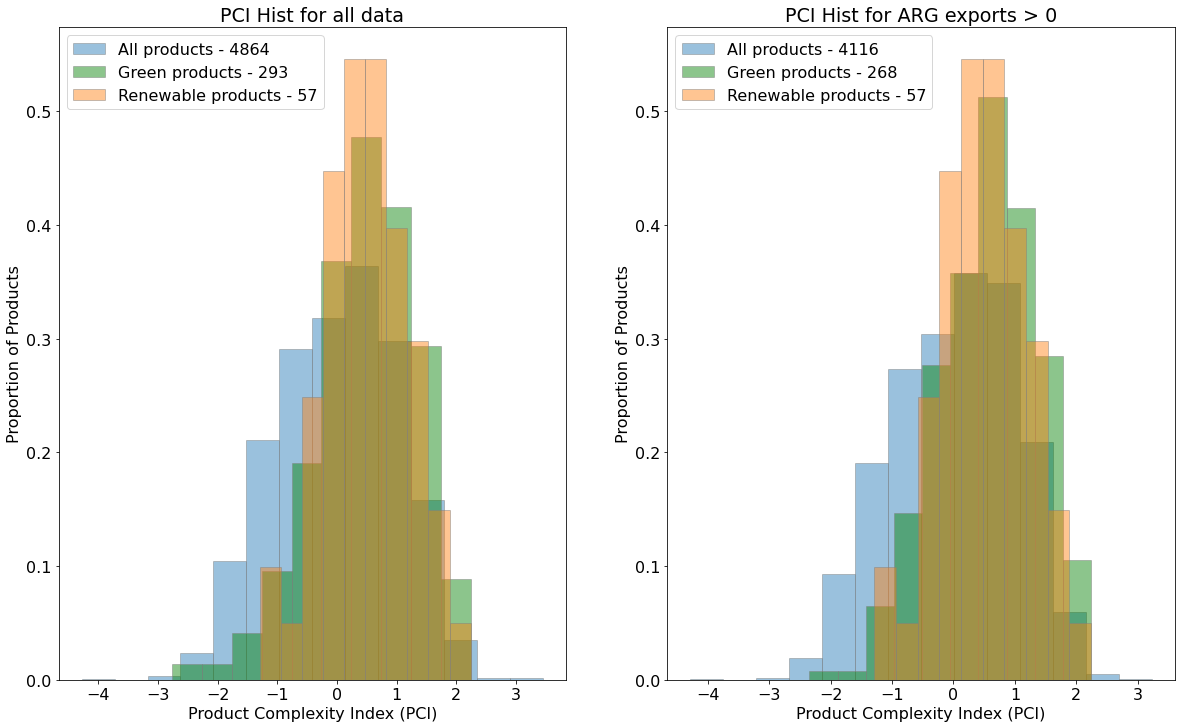

In [70]:
transp = 0.45

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
#fig.suptitle('PCI Histograms')

ax1.set_title('PCI Hist for all data')
ax1.hist(df_arg_all.PCI, density=True, alpha=transp, label=f'All products - {len(df_arg_all.PCI)}', ec='gray', bins=14)
ax1.hist(df_arg_green.PCI, density=True, alpha=transp, label=f'Green products - {len(df_arg_green.PCI)}', ec='gray', color='green')
ax1.hist(df_arg_renew.PCI, density=True, alpha=transp, label=f'Renewable products - {len(df_arg_renew.PCI)}', ec='gray')
ax1.set_xlabel('Product Complexity Index (PCI)')
ax1.set_ylabel('Proportion of Products')
ax1.legend()

ax2.set_title('PCI Hist for ARG exports > 0')
ax2.hist(df_arg_all.loc[df_arg_all.ARG_RCA > 0.0, 'PCI'], density=True, alpha=transp, label=f'All products - {len(df_arg_all.loc[df_arg_all.ARG_RCA > 0.0, "PCI"])}', ec='gray', bins=14)
ax2.hist(df_arg_green.loc[df_arg_green.ARG_RCA > 0.0, 'PCI'], density=True, alpha=transp, label=f'Green products - {len(df_arg_green.loc[df_arg_green.ARG_RCA > 0.0, "PCI"])}', ec='gray', color='green')
ax2.hist(df_arg_renew.loc[df_arg_renew.ARG_RCA > 0.0, 'PCI'], density=True, alpha=transp, label=f'Renewable products - {len(df_arg_renew.loc[df_arg_renew.ARG_RCA > 0.0, "PCI"])}', ec='gray')
ax2.set_xlabel('Product Complexity Index (PCI)')
ax2.set_ylabel('Proportion of Products')
ax2.legend()

In [71]:
# df de productos con informacion de China
code_new = 'CHN'

co_idx_n = np.searchsorted(locations, code_new)
co_idx_d_n = {code_new: co_idx_n}
co_idx_d_n

{'CHN': 16}

In [72]:
mode = 'green'
df_new_green = build_products_df(co_idx_d_n, mode)
df_new_green.to_csv(DATASETS_DIR + f'df_{mode}_products_{code_new}_{ANIO-VENTANA+1}_{ANIO}.csv')

Creating country CHN dataframe
DataFrame is of size 293


In [73]:
mode = 'renewable'
df_new_renew = build_products_df(co_idx_d_n, mode)
df_new_renew.to_csv(DATASETS_DIR + f'df_{mode}_products_{code_new}_{ANIO-VENTANA+1}_{ANIO}.csv')

Creating country CHN dataframe
DataFrame is of size 57


In [74]:
mode = 'all'
df_new_all = build_products_df(co_idx_d_n, mode)
df_new_all.to_csv(DATASETS_DIR + f'df_{mode}_products_{code_new}_{ANIO-VENTANA+1}_{ANIO}.csv')

Creating country CHN dataframe
DataFrame is of size 4864


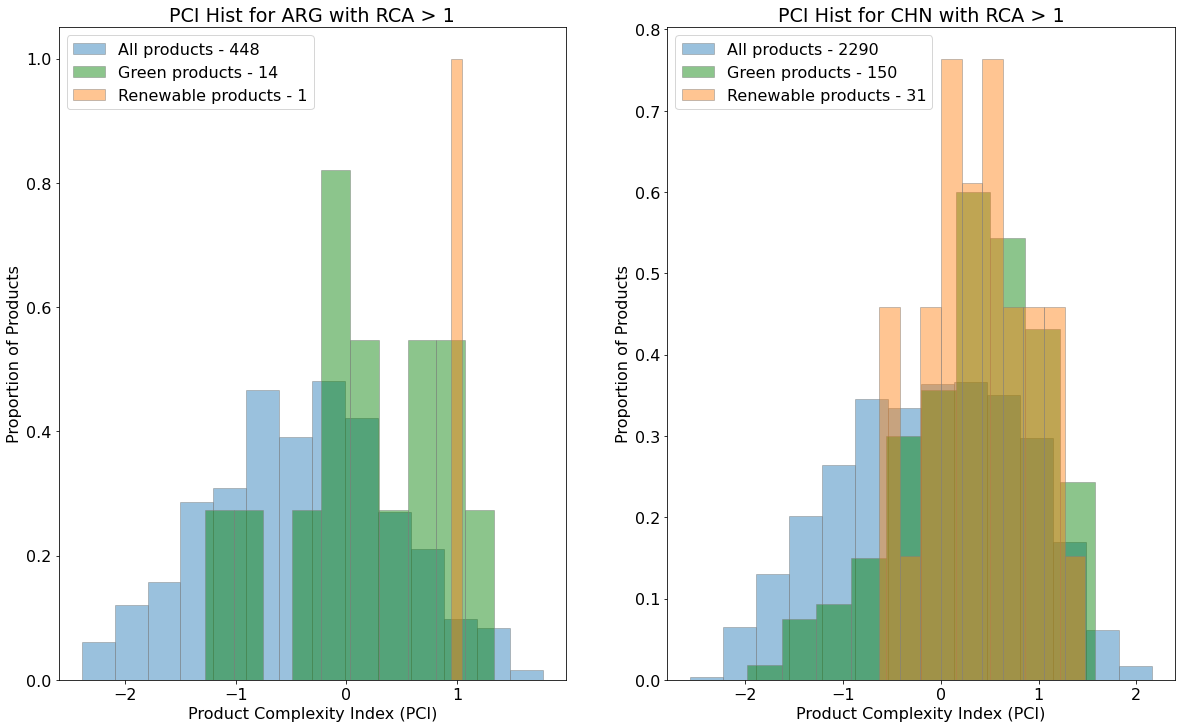

In [75]:
transp = 0.45

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
#fig.suptitle('PCI Histograms')

ax1.set_title('PCI Hist for ARG with RCA > 1')
ax1.hist(df_arg_all.loc[df_arg_all.ARG_RCA > 1.0, 'PCI'], density=True, alpha=transp, label=f'All products - {len(df_arg_all.loc[df_arg_all.ARG_RCA > 1.0, "PCI"])}', ec='gray', bins=14)
ax1.hist(df_arg_green.loc[df_arg_green.ARG_RCA > 1.0, 'PCI'], density=True, alpha=transp, label=f'Green products - {len(df_arg_green.loc[df_arg_green.ARG_RCA > 1.0, "PCI"])}', ec='gray', color='green')
ax1.hist(df_arg_renew.loc[df_arg_renew.ARG_RCA > 1.0, 'PCI'], density=False, alpha=transp, label=f'Renewable products - {len(df_arg_renew.loc[df_arg_renew.ARG_RCA > 1.0, "PCI"])}', ec='gray')
ax1.set_xlabel('Product Complexity Index (PCI)')
ax1.set_ylabel('Proportion of Products')
ax1.legend()

ax2.set_title('PCI Hist for CHN with RCA > 1')
ax2.hist(df_new_all.loc[df_new_all.CHN_RCA > 1.0, 'PCI'], density=True, alpha=transp, label=f'All products - {len(df_new_all.loc[df_new_all.CHN_RCA > 1.0, "PCI"])}', ec='gray', bins=14)
ax2.hist(df_new_green.loc[df_new_green.CHN_RCA > 1.0, 'PCI'], density=True, alpha=transp, label=f'Green products - {len(df_new_green.loc[df_new_green.CHN_RCA > 1.0, "PCI"])}', ec='gray', color='green')
ax2.hist(df_new_renew.loc[df_new_renew.CHN_RCA > 1.0, 'PCI'], density=True, alpha=transp, label=f'Renewable products - {len(df_new_renew.loc[df_new_renew.CHN_RCA > 1.0, "PCI"])}', ec='gray')
ax2.set_xlabel('Product Complexity Index (PCI)')
ax2.set_ylabel('Proportion of Products')
ax2.legend()

### Grafica proximidades entre paises

In [76]:
developed_codes = np.array(developed_codes)
developed_codes, regional_codes

(array(['CHN', 'ITA', 'ESP', 'FRA', 'DEU', 'TUR', 'POL', 'AUT', 'PRT',
        'IND', 'USA', 'JPN', 'CZE', 'DNK', 'GBR'], dtype='<U3'),
 array(['BRA', 'MEX', 'COL', 'ARG', 'PER', 'VEN', 'CHL', 'ECU', 'BOL',
        'PRY', 'URY'], dtype='<U3'))

In [77]:
dev_ids = np.searchsorted(locations, developed_codes)
reg_ids = np.searchsorted(locations, regional_codes)
dev_reg_ids = np.append(dev_ids, reg_ids)
dev_reg_codes = np.append(developed_codes, regional_codes)

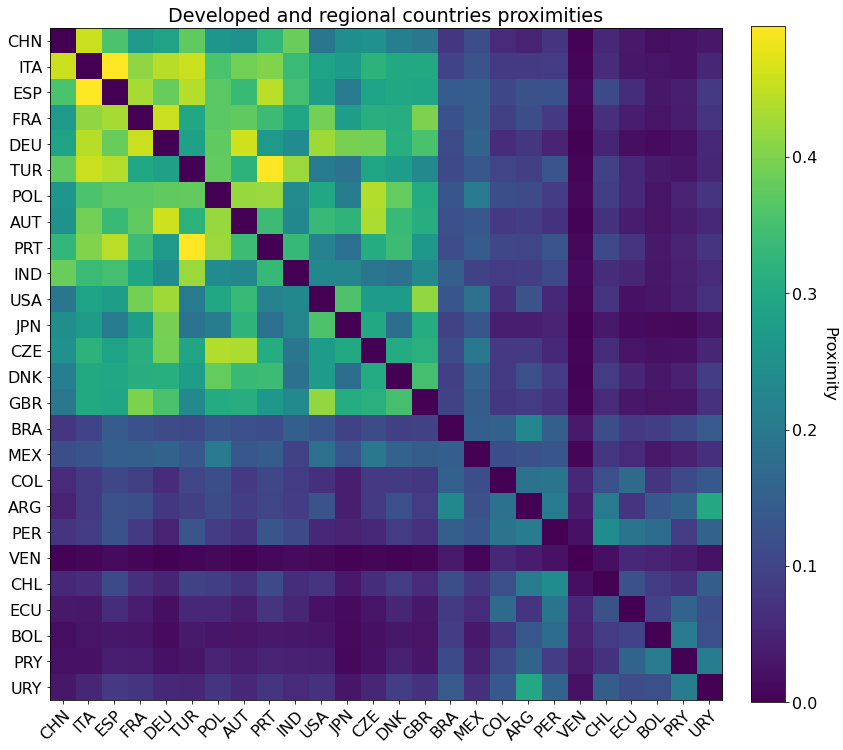

In [78]:
# proximities between developed and regional countries

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(proximity_c[dev_reg_ids][:, dev_reg_ids] - np.diag(np.ones(len(dev_reg_ids))))

ax.set_title('Developed and regional countries proximities')

cbar_kw = {}
cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Proximity', rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(dev_reg_ids)))
ax.set_yticks(np.arange(len(dev_reg_ids)))

ax.set_xticklabels(dev_reg_codes)
ax.set_yticklabels(dev_reg_codes)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
#for i in range(len(vegetables)):
#    for j in range(len(farmers)):
#        text = ax.text(j, i, harvest[i, j],
#                       ha="center", va="center", color="w")

#ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()
